<a href="https://colab.research.google.com/github/herysedra/ady_cov/blob/master/scr/modely_RP/R_tany.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
!pip install pynverse

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
import pickle

import datetime
import time
from datetime import date

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

from numpy import log,exp
from numpy.random import multinomial
from scipy.stats import uniform, gamma, gengamma, poisson, nbinom, expon
from scipy.integrate import quad

from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from pynverse import inversefunc

tilyvoa = pd.read_csv("/content/drive/My Drive/data/tilyvoa.csv")

mdg_databe = pd.read_csv("/content/drive/My Drive/data/databe mdg.csv")

dataw = pd.read_csv("/content/drive/My Drive/data/dataw.csv")

tilyvoafar = tilyvoa.groupby('Faritra')
tilyvoamdg = tilyvoafar.get_group('Madagasikara')
tilyvoamdg.set_index('Daty', inplace=True)
tilyvoamdg.index = pd.to_datetime(tilyvoamdg.index)

datawcount = dataw.groupby('Countries')

datawke = datawcount.get_group('Kenya')
datawke.set_index('DateRep', inplace=True)
datawke.index = pd.to_datetime(datawke.index, dayfirst =True)

datawcod = datawcount.get_group('Democratic_Republic_of_the_Congo')
datawcod.set_index('DateRep', inplace=True)
datawcod.index = pd.to_datetime(datawcod.index, dayfirst=True)

datawsa = datawcount.get_group('South_Africa')
datawsa.set_index('DateRep', inplace=True)
datawsa.index = pd.to_datetime(datawsa.index, dayfirst=True)

dataweg = datawcount.get_group('Egypt')
dataweg.set_index('DateRep', inplace=True)
dataweg.index = pd.to_datetime(dataweg.index, dayfirst=True)

datawng = datawcount.get_group('Nigeria')
datawng.set_index('DateRep', inplace=True)
datawng.index = pd.to_datetime(datawng.index, dayfirst=True)

path_to_save = '/content/drive/My Drive/sary/'
path_data = '/content/drive/My Drive/data/'

# Kenya

In [4]:
# Voa vaovao (observed incidence)
Ivao = datawke['Cases']

dIvao = pd.DataFrame(data =Ivao)

dIvao.sort_index(inplace=True)

# ireo daty fanombohana sy fiafaran'ny antontan'isa raisina
# (Time range of data used for the estimation)

daty_data_manom = datetime.date(2020,5,1)
daty_data_mifar = datetime.date(2020,6,14)

datyt = daty_data_mifar

format_date = lambda date_py: '{}-{}-{}'.format(date_py.year, date_py.month, date_py.day)
datyf_data_manom = format_date(daty_data_manom)
datyf_data_mifar = format_date(daty_data_mifar)

# 0/ Discretization of the serial interval distribution

#Tombana mialoha (prior distributions)
#si_sh = 1/(0.62**2) # Report 13
#si_sc = 6.5/si_sh

si_sh = (6.48**2)/(3.83**2) # Jereo Imperial Covid-19 COVID-19 response team: Short-term forecasts
si_sc = 6.48/si_sh

def discr_si(t):
  if t == 0:
    discrsi = 0
  elif t == 1:
    discrsi = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)
  else:
    discrsi = gengamma.cdf(t+1/2, si_sh, 1, loc = 0, scale = si_sc) - gengamma.cdf(t-1/2, si_sh, 1, loc = 0, scale = si_sc)
  return discrsi

# 1/ The total incidence over a generic window (t-k+1,t)
# Ireh(t,k) = sum(i = 0 to k-1) Ivao(t - i))

def Ireh(t,k):
  Irehv = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      Irehv = Irehv + dIvao['Cases'].loc[format_date(t - datetime.timedelta(days = i))]
  else:
    for i in range(k):
      Irehv = Irehv + dIvao['Cases'].loc[format_date(t - datetime.timedelta(days = i))]
  return Irehv

# 2/ Tool to compute the total infectiousness over a generic window (t-k+1,t)
# Isi(t,k) = sum(i=0 to k-1) Ivao(t - i)*discr_si(i)

# The definition of Isi(t,k) does not include the term Ivao(t) for i = 0 (because discr_si(0) =0)
# so we can start the sum from i = 1; but it includes the last term Ivao(t - k + 1)*discr_si(k - 1) for i = k-1. 

def Isi(t,k):
  Ivaosi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range(1,(t - daty_data_manom).days + 1):
      Ivaosi = Ivaosi + dIvao['Cases'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  else:
    for i in range(1,k):
      Ivaosi = Ivaosi + dIvao['Cases'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  return Ivaosi

# The total infectiousness before t

# lsi(t) := sum(i=0 to t-1) Ivao(t - i)*discr_si(i)

def lsi(t):
  return Isi(t, (t - daty_data_manom).days +1)

  # for checking, take for example t = daty_data_manom + datetime.timedelta(days = 3)

# 3/ The sum of total infectiousness before t over a generic window (t-k+1,t)
# tlsi(t) := sum(i=t-k+1 to t)lsi(i)

def tlsi(t,k):
  tlsi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  else:
    for i in range(k):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  return tlsi

# 4/ The shape parameters of the posterior predictive negative binomial of I(t+1)

# pnb(t,k) = lsi(t+1)*Gamma_post_scale(R(t,k))/(1 + lsi(t+1)*Gamma_post_scale(R(t,k)))

def pnb(t,k):
  return lsi(t+datetime.timedelta(days = 1))/(1/si_sc + tlsi(t,k) + lsi(t+datetime.timedelta(days = 1)))

# pnb(t,k) dia ny taha herjika hoan'ny NB hoan'ny I(t+1).

# 5/ Use the pmf of the posterior predictive negative binomial to compute
# each additive contribution at time s then for-loop for s in the time interval

def lpr(t,k):
  return -np.log(nbinom.pmf(dIvao['Cases'].loc[format_date(t + datetime.timedelta(days = 1))], si_sh + Ireh(t,k), pnb(t,k)))


In [ ]:
print(Ireh(datyt- datetime.timedelta(days = 1),9))
print(dIvao['Cases'].loc[format_date(datyt)])
print(pnb(datyt- datetime.timedelta(days = 1),9))
print(nbinom.pmf(1000,1091,0.10897))

2.862545930506037
1089
152
0.10897196740011042
0.0


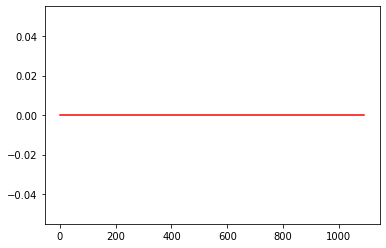

In [ ]:
# 100 linearly spaced numbers
x = np.linspace(0.1,1091,100)


# setting the axes at the centre
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)


# plot the functions
plt.plot(x,nbinom.pmf(x,1091,0.10897), 'r')

# show the plot
plt.show()

In [ ]:
# 6/ Computation of the Accumulated Predictive Error

# APE9_part1 

APEt91 = []
Prt91 = []

APE91 = 0

for i in range((daty_data_mifar - daty_data_manom).days - 9 + 1):
  t = daty_data_mifar - datetime.timedelta(days = i+1) 
  k = 9
  APE91 = APE91 + lpr(t,k)
  APEt91.append((lpr(t,k),t))
  Prt91.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE91 =', APE91)
print('APEt91 =', APEt91)
print('Prt91 =', Prt91)

# APE9_part2 

APEt92 = []
Prt92 = []

APE92 = 0
for i in range(7):
  t = daty_data_manom - datetime.timedelta(days = i -7)
  k = 9 - 1 - i
  APE92 = APE92 + lpr(t,k) 
  APEt92.append((lpr(t,k),t,k))
  Prt92.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE92 =', APE92)
print('APEt92=', APEt92)
print('Prt92=', Prt92)

# For t_man such that Ivao(t_man) = Ivao(t_man + 1) = 0, we have :
# lsi(t_man + 1) = tlsi(t_man + 1, 2) = Ireh(t_man + 1, 2) = 0,
# so that pnb(t_man + 1, 2) = 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in log


For k = 9, APE91 = inf
APEt91 = [(inf, datetime.date(2020, 6, 13)), (inf, datetime.date(2020, 6, 12)), (inf, datetime.date(2020, 6, 11)), (inf, datetime.date(2020, 6, 10)), (inf, datetime.date(2020, 6, 9)), (inf, datetime.date(2020, 6, 8)), (inf, datetime.date(2020, 6, 7)), (inf, datetime.date(2020, 6, 6)), (inf, datetime.date(2020, 6, 5)), (inf, datetime.date(2020, 6, 4)), (inf, datetime.date(2020, 6, 3)), (inf, datetime.date(2020, 6, 2)), (inf, datetime.date(2020, 6, 1)), (inf, datetime.date(2020, 5, 31)), (inf, datetime.date(2020, 5, 30)), (inf, datetime.date(2020, 5, 29)), (inf, datetime.date(2020, 5, 28)), (691.7429254447461, datetime.date(2020, 5, 27)), (inf, datetime.date(2020, 5, 26)), (679.2554491320774, datetime.date(2020, 5, 25)), (inf, datetime.date(2020, 5, 24)), (722.3230744778152, datetime.date(2020, 5, 23)), (638.5212133687154, datetime.date(2020, 5, 22)), (496.29473813444207, datetime.date(2020, 5, 21)), (465.50106372714225, datetime.date(2020, 5, 20)), (450.0508974615

In [ ]:
# APEk part 1 for k =/= 9

# for i in range(t_mif - t_man -j)

APEk1 = []
#APEt21 = []
for j in range(2,9):
  APEj1 = 0
  for i in range(round(((daty_data_mifar - daty_data_manom).days) - j)):
    t = daty_data_mifar - datetime.timedelta(days = i+1) 
    k = j
    APEj1 = APEj1 + lpr(t,k)
   # APEt21.append(lpr(t,k))
  APEk1.append(APEj1)

print('APEk1 =', APEk1)
#print('APEt21 =', APEt21)

# APEk part 2 for k =/= 9

Prk2 = []

APEk2 = []

for j in range(2,9):
  APEj2 = 0
  for i in range(j-1):
    t = daty_data_manom + datetime.timedelta(days = j - i - 1)
    k = j - i
    APEj2 = APEj2 + lpr(t,k)
  APEk2.append(APEj2)

print('APEk2 =', APEk2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in log


APEk1 = [1928.1697504766346, 5589.027951979663, 10150.506958188647, inf, inf, inf, inf]
APEk2 = [3.5021553949482076, 6.881173543896377, 24.769110720547936, 51.06905539201908, 116.31666517326889, 269.4689724885229, 502.1419232786251]


In [ ]:
# APEk for k = 2,...,8

APEk = [x + y for x, y in zip(APEk1, APEk2)]

# APE9
APE9 = APE91 + APE92

APE = APEk + [APE9]
kk = APE.index(min(APE)) +2
print('APE9 =', APE9)
print('APEk =', APEk)
print('APE =', APE)
print(kk)


APE9 = inf
APEk = [1931.6719058715828, 5595.90912552356, 10175.276068909196, inf, inf, inf, inf]
APE = [1931.6719058715828, 5595.90912552356, 10175.276068909196, inf, inf, inf, inf, inf]
2


## Fifidianana ireo taha mialoha (prior parameters)

In [ ]:

  #shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh
  # Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc

def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[0.01, 1e+11])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


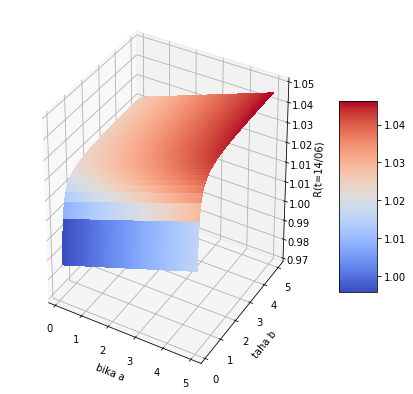

In [ ]:
# Variation of R(datyab) with rapport to the prior parameters

datyab = daty_data_mifar

fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')

# Make data.
X = np.linspace(0.1,5,100)
Y = np.linspace(0.1,5,100)
X, Y = np.meshgrid(X, Y)
Z = func_sh(datyab)(X)*func_sc(datyab)(Y)
W = X*Y
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#surf = ax.plot_surface(X, Y, W, cmap=cm.coolwarm,
 #                      linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0.97, 1.05)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set(xlabel ='bika a', ylabel = "taha b", zlabel = 'R(t=14/06)')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.savefig(path_to_save+'Rt15146_ke.eps')

plt.show()

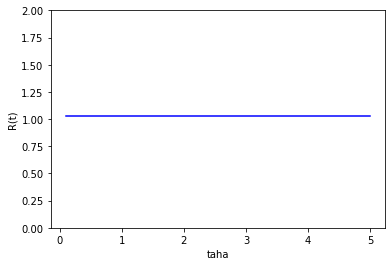

taha* = 1
R(t= 2020-06-14 ) = 1.0259259434519956 = bika*


In [ ]:
# R(t) when equality between the prior and the posterior

# 100 linearly spaced numbers
x = np.linspace(0.1,5,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the function
plt.plot(x, x*funcsh_inv(datyab)(x/func_sc(datyab)(x)), 'blue')

ax.set_ylim(0,2)
ax.set(xlabel ='taha', ylabel = "R(t)")


# show the plot
plt.show()

print('taha* = 1')
print('R(t=',datyab,') =', funcsh_inv(datyab)(1/func_sc(datyab)(1)), '= bika*')


## Fanombanana ny Rt

In [ ]:
#shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh

# Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc


def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[1e-11, 1e+11])

def Rt_salan(t):
    ffunc_sh = func_sh(t)
    ffunc_sc = func_sc(t)
    ffuncsh_inv = funcsh_inv(t)
    return ffuncsh_inv(1/ffunc_sc(1))

# The 95th and 5th percentiles of Rt

def perc75(t):
    return gengamma.ppf(0.75, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))

def perc25(t):
    return gengamma.ppf(0.25, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))


def Rtps_sal(t):
  return dIvao['Cases'].loc[format_date(t)]/lsi(t)

print("Kajy mivantana ny R hoan'ny", daty_data_mifar, ':', Rtps_sal(daty_data_mifar))

daty_oh1 = datetime.date(2020,6,8)
print("Salan'isa R hoan'ny", daty_oh1, ':', Rt_salan(daty_oh1))
print("Kartily @ 75% R hoan'ny", daty_oh1, ':', perc75(daty_oh1))
print("Kartily @ 25% R hoan'ny", daty_oh1, ':', perc25(daty_oh1))

print("Salan'isa R hoan'ny", daty_data_mifar, ':', Rt_salan(daty_data_mifar))
print("Kartily @ 75% R hoan'ny", daty_data_mifar, ':', perc75(daty_data_mifar))
print("Kartily @ 25% R hoan'ny", daty_data_mifar, ':', perc25(daty_data_mifar))


Kajy mivantana ny R hoan'ny 2020-06-14 : 1.293075038937982
Salan'isa R hoan'ny 2020-06-08 : 1.4631439316639365
Kartily @ 75% R hoan'ny 2020-06-08 : 1.5197163613078295
Kartily @ 25% R hoan'ny 2020-06-08 : 1.4047664443231398
Salan'isa R hoan'ny 2020-06-14 : 1.0259259461873413
Kartily @ 75% R hoan'ny 2020-06-14 : 1.0695139539052065
Kartily @ 25% R hoan'ny 2020-06-14 : 0.9808044839649696


## DRC Congo

In [ ]:
# Voa vaovao (observed incidence)
Ivao = datawcod['Cases']

dIvao = pd.DataFrame(data =Ivao)

dIvao.sort_index(inplace=True)

# ireo daty fanombohana sy fiafaran'ny antontan'isa raisina
# (Time range of data used for the estimation)

daty_data_manom = datetime.date(2020,5,1)
daty_data_mifar = datetime.date(2020,6,14)

datyt = daty_data_mifar

format_date = lambda date_py: '{}-{}-{}'.format(date_py.year, date_py.month, date_py.day)
datyf_data_manom = format_date(daty_data_manom)
datyf_data_mifar = format_date(daty_data_mifar)

# 0/ Discretization of the serial interval distribution

#Tombana mialoha (prior distributions)
#si_sh = 1/(0.62**2) # Report 13
#si_sc = 6.5/si_sh

si_sh = (6.48**2)/(3.83**2) # Jereo Imperial Covid-19 COVID-19 response team: Short-term forecasts
si_sc = 6.48/si_sh

def discr_si(t):
  if t == 0:
    discrsi = 0
  elif t == 1:
    discrsi = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)
  else:
    discrsi = gengamma.cdf(t+1/2, si_sh, 1, loc = 0, scale = si_sc) - gengamma.cdf(t-1/2, si_sh, 1, loc = 0, scale = si_sc)
  return discrsi

# 1/ The total incidence over a generic window (t-k+1,t)
# Ireh(t,k) = sum(i = 0 to k-1) Ivao(t - i))

def Ireh(t,k):
  Irehv = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      Irehv = Irehv + dIvao['Cases'].loc[format_date(t - datetime.timedelta(days = i))]
  else:
    for i in range(k):
      Irehv = Irehv + dIvao['Cases'].loc[format_date(t - datetime.timedelta(days = i))]
  return Irehv

# 2/ Tool to compute the total infectiousness over a generic window (t-k+1,t)
# Isi(t,k) = sum(i=0 to k-1) Ivao(t - i)*discr_si(i)

# The definition of Isi(t,k) does not include the term Ivao(t) for i = 0 (because discr_si(0) =0)
# so we can start the sum from i = 1; but it includes the last term Ivao(t - k + 1)*discr_si(k - 1) for i = k-1. 

def Isi(t,k):
  Ivaosi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range(1,(t - daty_data_manom).days + 1):
      Ivaosi = Ivaosi + dIvao['Cases'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  else:
    for i in range(1,k):
      Ivaosi = Ivaosi + dIvao['Cases'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  return Ivaosi

# The total infectiousness before t

# lsi(t) := sum(i=0 to t-1) Ivao(t - i)*discr_si(i)

def lsi(t):
  return Isi(t, (t - daty_data_manom).days +1)

  # for checking, take for example t = daty_data_manom + datetime.timedelta(days = 3)

# 3/ The sum of total infectiousness before t over a generic window (t-k+1,t)
# tlsi(t) := sum(i=t-k+1 to t)lsi(i)

def tlsi(t,k):
  tlsi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  else:
    for i in range(k):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  return tlsi

# 4/ The shape parameters of the posterior predictive negative binomial of I(t+1)

# pnb(t,k) = lsi(t+1)*Gamma_post_scale(R(t,k))/(1 + lsi(t+1)*Gamma_post_scale(R(t,k)))

def pnb(t,k):
  return lsi(t+datetime.timedelta(days = 1))/(1/si_sc + tlsi(t,k) + lsi(t+datetime.timedelta(days = 1)))

# pnb(t,k) dia ny taha herjika hoan'ny NB hoan'ny I(t+1).

# 5/ Use the pmf of the posterior predictive negative binomial to compute
# each additive contribution at time s then for-loop for s in the time interval

def lpr(t,k):
  return -np.log(nbinom.pmf(dIvao['Cases'].loc[format_date(t + datetime.timedelta(days = 1))], si_sh + Ireh(t,k), pnb(t,k)))


In [ ]:
# 6/ Computation of the Accumulated Predictive Error

# APE9_part1 

APEt91 = []
Prt91 = []

APE91 = 0

for i in range((daty_data_mifar - daty_data_manom).days - 9 + 1):
  t = daty_data_mifar - datetime.timedelta(days = i+1) 
  k = 9
  APE91 = APE91 + lpr(t,k)
  APEt91.append((lpr(t,k),t))
  Prt91.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE91 =', APE91)
print('APEt91 =', APEt91)
print('Prt91 =', Prt91)

# APE9_part2 

APEt92 = []
Prt92 = []

APE92 = 0
for i in range(7):
  t = daty_data_manom - datetime.timedelta(days = i -7)
  k = 9 - 1 - i
  APE92 = APE92 + lpr(t,k) 
  APEt92.append((lpr(t,k),t,k))
  Prt92.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE92 =', APE92)
print('APEt92=', APEt92)
print('Prt92=', Prt92)

# For t_man such that Ivao(t_man) = Ivao(t_man + 1) = 0, we have :
# lsi(t_man + 1) = tlsi(t_man + 1, 2) = Ireh(t_man + 1, 2) = 0,
# so that pnb(t_man + 1, 2) = 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in log


For k = 9, APE91 = inf
APEt91 = [(inf, datetime.date(2020, 6, 13)), (inf, datetime.date(2020, 6, 12)), (inf, datetime.date(2020, 6, 11)), (inf, datetime.date(2020, 6, 10)), (inf, datetime.date(2020, 6, 9)), (inf, datetime.date(2020, 6, 8)), (inf, datetime.date(2020, 6, 7)), (inf, datetime.date(2020, 6, 6)), (inf, datetime.date(2020, 6, 5)), (inf, datetime.date(2020, 6, 4)), (inf, datetime.date(2020, 6, 3)), (inf, datetime.date(2020, 6, 2)), (inf, datetime.date(2020, 6, 1)), (inf, datetime.date(2020, 5, 31)), (inf, datetime.date(2020, 5, 30)), (inf, datetime.date(2020, 5, 29)), (inf, datetime.date(2020, 5, 28)), (inf, datetime.date(2020, 5, 27)), (inf, datetime.date(2020, 5, 26)), (inf, datetime.date(2020, 5, 25)), (inf, datetime.date(2020, 5, 24)), (inf, datetime.date(2020, 5, 23)), (inf, datetime.date(2020, 5, 22)), (inf, datetime.date(2020, 5, 21)), (inf, datetime.date(2020, 5, 20)), (inf, datetime.date(2020, 5, 19)), (743.7469247408213, datetime.date(2020, 5, 18)), (inf, datetime.da

In [ ]:
# APEk part 1 for k =/= 9

# for i in range(t_mif - t_man -j)

APEk1 = []
#APEt21 = []
for j in range(2,9):
  APEj1 = 0
  for i in range(round(((daty_data_mifar - daty_data_manom).days) - j)):
    t = daty_data_mifar - datetime.timedelta(days = i+1) 
    k = j
    APEj1 = APEj1 + lpr(t,k)
   # APEt21.append(lpr(t,k))
  APEk1.append(APEj1)

print('APEk1 =', APEk1)
#print('APEt21 =', APEt21)

# APEk part 2 for k =/= 9

Prk2 = []

APEk2 = []

for j in range(2,9):
  APEj2 = 0
  for i in range(j-1):
    t = daty_data_manom + datetime.timedelta(days = j - i - 1)
    k = j - i
    APEj2 = APEj2 + lpr(t,k)
  APEk2.append(APEj2)

print('APEk2 =', APEk2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in log


APEk1 = [3301.817750973744, 8686.150295920588, inf, inf, inf, inf, inf]
APEk2 = [6.314198166242832, 78.70103925155489, 231.90730858287463, 379.0433825202206, 460.378705790229, 873.2783655871028, 1339.3884493742316]


In [ ]:
# APEk for k = 2,...,8

APEk = [x + y for x, y in zip(APEk1, APEk2)]

# APE9
APE9 = APE91 + APE92

APE = APEk + [APE9]
kk = APE.index(min(APE)) +2
print('APE9 =', APE9)
print('APEk =', APEk)
print('APE =', APE)
print(kk)


APE9 = inf
APEk = [3308.131949139987, 8764.851335172143, inf, inf, inf, inf, inf]
APE = [3308.131949139987, 8764.851335172143, inf, inf, inf, inf, inf, inf]
2


## Fifidianana ireo taha mialoha (prior parameters)

In [ ]:

  #shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh
  # Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc

def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[0.01, 1e+11])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


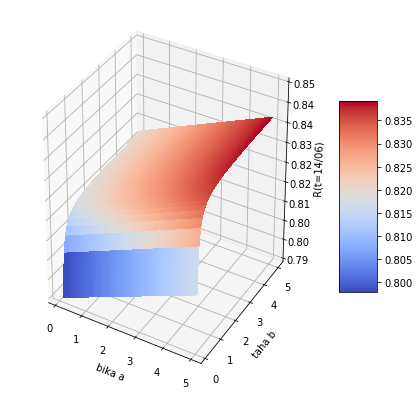

In [ ]:
# Variation of R(datyab) with rapport to the prior parameters

datyab = daty_data_mifar

fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')

# Make data.
X = np.linspace(0.1,5,100)
Y = np.linspace(0.1,5,100)
X, Y = np.meshgrid(X, Y)
Z = func_sh(datyab)(X)*func_sc(datyab)(Y)
W = X*Y
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#surf = ax.plot_surface(X, Y, W, cmap=cm.coolwarm,
 #                      linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0.79, 0.85)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set(xlabel ='bika a', ylabel = "taha b", zlabel = 'R(t=14/06)')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.savefig(path_to_save+'Rt15146_drc.eps')

plt.show()

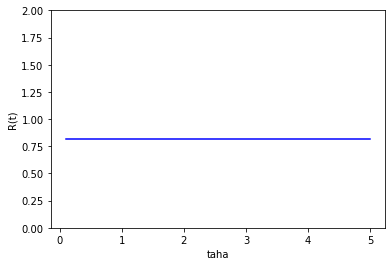

taha* = 1
R(t= 2020-06-14 ) = 0.8202446650923532 = bika*


In [ ]:
# R(t) when equality between the prior and the posterior

# 100 linearly spaced numbers
x = np.linspace(0.1,5,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the function
plt.plot(x, x*funcsh_inv(datyab)(x/func_sc(datyab)(x)), 'blue')

ax.set_ylim(0,2)
ax.set(xlabel ='taha', ylabel = "R(t)")


# show the plot
plt.show()

print('taha* = 1')
print('R(t=',datyab,') =', funcsh_inv(datyab)(1/func_sc(datyab)(1)), '= bika*')


## Fanombanana ny Rt

In [ ]:
#shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh

# Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc


def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[1e-11, 1e+11])

def Rt_salan(t):
    ffunc_sh = func_sh(t)
    ffunc_sc = func_sc(t)
    ffuncsh_inv = funcsh_inv(t)
    return ffuncsh_inv(1/ffunc_sc(1))

# The 95th and 5th percentiles of Rt

def perc75(t):
    return gengamma.ppf(0.75, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))

def perc25(t):
    return gengamma.ppf(0.25, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))


def Rtps_sal(t):
  return dIvao['Cases'].loc[format_date(t)]/lsi(t)

print("Kajy mivantana ny R hoan'ny", daty_data_mifar, ':', Rtps_sal(daty_data_mifar))

daty_oh1 = datetime.date(2020,6,8)
print("Salan'isa R hoan'ny", daty_oh1, ':', Rt_salan(daty_oh1))
print("Kartily @ 75% R hoan'ny", daty_oh1, ':', perc75(daty_oh1))
print("Kartily @ 25% R hoan'ny", daty_oh1, ':', perc25(daty_oh1))

print("Salan'isa R hoan'ny", daty_data_mifar, ':', Rt_salan(daty_data_mifar))
print("Kartily @ 75% R hoan'ny", daty_data_mifar, ':', perc75(daty_data_mifar))
print("Kartily @ 25% R hoan'ny", daty_data_mifar, ':', perc25(daty_data_mifar))


Kajy mivantana ny R hoan'ny 2020-06-14 : 0.6829108474195255
Salan'isa R hoan'ny 2020-06-08 : 1.0047289020057888
Kartily @ 75% R hoan'ny 2020-06-08 : 1.0465819381379342
Kartily @ 25% R hoan'ny 2020-06-08 : 0.9614333055436355
Salan'isa R hoan'ny 2020-06-14 : 0.8202446694038187
Kartily @ 75% R hoan'ny 2020-06-14 : 0.8576955732515306
Kartily @ 25% R hoan'ny 2020-06-14 : 0.7813737887702457


In [ ]:
# Plotting everything except the first 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_lst = []

data_Rt_lst = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) -7)):
  t = daty_data_manom + datetime.timedelta(days = i+1 +7)
  data_amboar = [gengamma.rvs( func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1)) for j in range(400)]
  daty_lst.append(formatf_date(t))
  data_Rt_lst.append(data_amboar)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


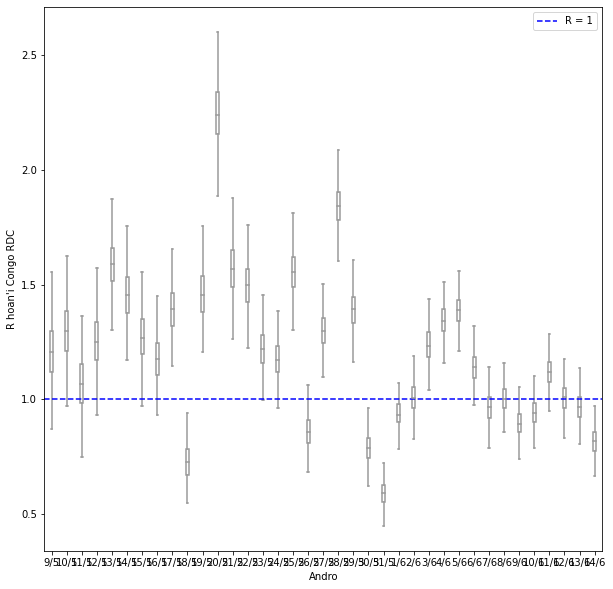

In [ ]:
# Plotting everything except the first 7 days


fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(daty_lst, data_Rt_lst, color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'i Congo RDC")
ax.legend(loc= 'best')


plt.savefig(path_to_save+'Rt15146_drc.eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


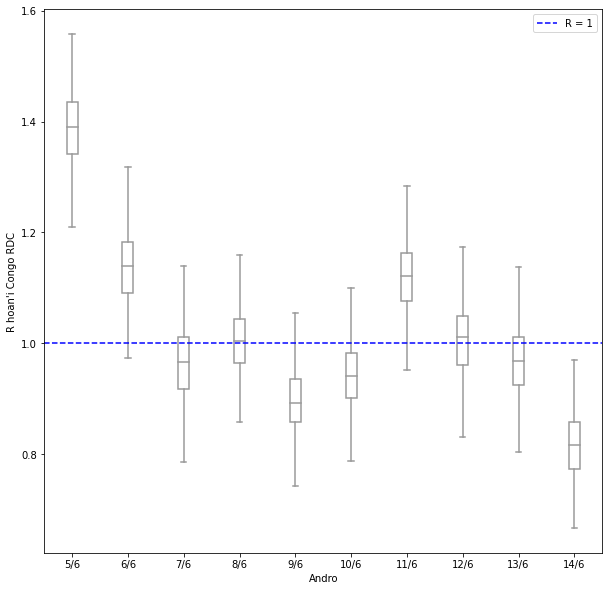

In [ ]:
# Plotting the last 10 days before daty_data_mifar


fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(daty_lst[len(daty_lst)-10:len(daty_lst)], data_Rt_lst[len(daty_lst)-10:len(daty_lst)], color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'i Congo RDC")
ax.legend(loc= 'best')


plt.savefig(path_to_save+'Rt1514610_drc.eps')
plt.show()

# South Africa

In [4]:
# Voa vaovao (observed incidence)
Ivao = datawsa['Cases']

dIvao = pd.DataFrame(data =Ivao)

dIvao.sort_index(inplace=True)

# ireo daty fanombohana sy fiafaran'ny antontan'isa raisina
# (Time range of data used for the estimation)

daty_data_manom = datetime.date(2020,5,1)
daty_data_mifar = datetime.date(2020,6,14)

datyt = daty_data_mifar

format_date = lambda date_py: '{}-{}-{}'.format(date_py.year, date_py.month, date_py.day)
datyf_data_manom = format_date(daty_data_manom)
datyf_data_mifar = format_date(daty_data_mifar)

# 0/ Discretization of the serial interval distribution

#Tombana mialoha (prior distributions)
#si_sh = 1/(0.62**2) # Report 13
#si_sc = 6.5/si_sh

si_sh = (6.48**2)/(3.83**2) # Jereo Imperial Covid-19 COVID-19 response team: Short-term forecasts
si_sc = 6.48/si_sh

def discr_si(t):
  if t == 0:
    discrsi = 0
  elif t == 1:
    discrsi = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)
  else:
    discrsi = gengamma.cdf(t+1/2, si_sh, 1, loc = 0, scale = si_sc) - gengamma.cdf(t-1/2, si_sh, 1, loc = 0, scale = si_sc)
  return discrsi

# 1/ The total incidence over a generic window (t-k+1,t)
# Ireh(t,k) = sum(i = 0 to k-1) Ivao(t - i))

def Ireh(t,k):
  Irehv = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      Irehv = Irehv + dIvao['Cases'].loc[format_date(t - datetime.timedelta(days = i))]
  else:
    for i in range(k):
      Irehv = Irehv + dIvao['Cases'].loc[format_date(t - datetime.timedelta(days = i))]
  return Irehv

# 2/ Tool to compute the total infectiousness over a generic window (t-k+1,t)
# Isi(t,k) = sum(i=0 to k-1) Ivao(t - i)*discr_si(i)

# The definition of Isi(t,k) does not include the term Ivao(t) for i = 0 (because discr_si(0) =0)
# so we can start the sum from i = 1; but it includes the last term Ivao(t - k + 1)*discr_si(k - 1) for i = k-1. 

def Isi(t,k):
  Ivaosi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range(1,(t - daty_data_manom).days + 1):
      Ivaosi = Ivaosi + dIvao['Cases'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  else:
    for i in range(1,k):
      Ivaosi = Ivaosi + dIvao['Cases'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  return Ivaosi

# The total infectiousness before t

# lsi(t) := sum(i=0 to t-1) Ivao(t - i)*discr_si(i)

def lsi(t):
  return Isi(t, (t - daty_data_manom).days +1)

  # for checking, take for example t = daty_data_manom + datetime.timedelta(days = 3)

# 3/ The sum of total infectiousness before t over a generic window (t-k+1,t)
# tlsi(t) := sum(i=t-k+1 to t)lsi(i)

def tlsi(t,k):
  tlsi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  else:
    for i in range(k):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  return tlsi

# 4/ The shape parameters of the posterior predictive negative binomial of I(t+1)

# pnb(t,k) = lsi(t+1)*Gamma_post_scale(R(t,k))/(1 + lsi(t+1)*Gamma_post_scale(R(t,k)))

def pnb(t,k):
  return lsi(t+datetime.timedelta(days = 1))/(1/si_sc + tlsi(t,k) + lsi(t+datetime.timedelta(days = 1)))

# pnb(t,k) dia ny taha herjika hoan'ny NB hoan'ny I(t+1).

# 5/ Use the pmf of the posterior predictive negative binomial to compute
# each additive contribution at time s then for-loop for s in the time interval

def lpr(t,k):
  return -np.log(nbinom.pmf(dIvao['Cases'].loc[format_date(t + datetime.timedelta(days = 1))], si_sh + Ireh(t,k), pnb(t,k)))


In [6]:
# 6/ Computation of the Accumulated Predictive Error

# APE9_part1 

APEt91 = []
Prt91 = []

APE91 = 0

for i in range((daty_data_mifar - daty_data_manom).days - 9 + 1):
  t = daty_data_mifar - datetime.timedelta(days = i+1) 
  k = 9
  APE91 = APE91 + lpr(t,k)
  APEt91.append((lpr(t,k),t))
  Prt91.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE91 =', APE91)
print('APEt91 =', APEt91)
print('Prt91 =', Prt91)

# APE9_part2 

APEt92 = []
Prt92 = []

APE92 = 0
for i in range(7):
  t = daty_data_manom - datetime.timedelta(days = i -7)
  k = 9 - 1 - i
  APE92 = APE92 + lpr(t,k) 
  APEt92.append((lpr(t,k),t,k))
  Prt92.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE92 =', APE92)
print('APEt92=', APEt92)
print('Prt92=', Prt92)

# For t_man such that Ivao(t_man) = Ivao(t_man + 1) = 0, we have :
# lsi(t_man + 1) = tlsi(t_man + 1, 2) = Ireh(t_man + 1, 2) = 0,
# so that pnb(t_man + 1, 2) = 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in log


For k = 9, APE91 = inf
APEt91 = [(inf, datetime.date(2020, 6, 13)), (inf, datetime.date(2020, 6, 12)), (inf, datetime.date(2020, 6, 11)), (inf, datetime.date(2020, 6, 10)), (inf, datetime.date(2020, 6, 9)), (inf, datetime.date(2020, 6, 8)), (inf, datetime.date(2020, 6, 7)), (inf, datetime.date(2020, 6, 6)), (inf, datetime.date(2020, 6, 5)), (inf, datetime.date(2020, 6, 4)), (inf, datetime.date(2020, 6, 3)), (inf, datetime.date(2020, 6, 2)), (inf, datetime.date(2020, 6, 1)), (inf, datetime.date(2020, 5, 31)), (inf, datetime.date(2020, 5, 30)), (inf, datetime.date(2020, 5, 29)), (inf, datetime.date(2020, 5, 28)), (inf, datetime.date(2020, 5, 27)), (inf, datetime.date(2020, 5, 26)), (inf, datetime.date(2020, 5, 25)), (inf, datetime.date(2020, 5, 24)), (inf, datetime.date(2020, 5, 23)), (inf, datetime.date(2020, 5, 22)), (inf, datetime.date(2020, 5, 21)), (inf, datetime.date(2020, 5, 20)), (inf, datetime.date(2020, 5, 19)), (inf, datetime.date(2020, 5, 18)), (inf, datetime.date(2020, 5, 17

In [7]:
# APEk part 1 for k =/= 9

# for i in range(t_mif - t_man -j)

APEk1 = []
#APEt21 = []
for j in range(2,9):
  APEj1 = 0
  for i in range(round(((daty_data_mifar - daty_data_manom).days) - j)):
    t = daty_data_mifar - datetime.timedelta(days = i+1) 
    k = j
    APEj1 = APEj1 + lpr(t,k)
   # APEt21.append(lpr(t,k))
  APEk1.append(APEj1)

print('APEk1 =', APEk1)
#print('APEt21 =', APEt21)

# APEk part 2 for k =/= 9

Prk2 = []

APEk2 = []

for j in range(2,9):
  APEj2 = 0
  for i in range(j-1):
    t = daty_data_manom + datetime.timedelta(days = j - i - 1)
    k = j - i
    APEj2 = APEj2 + lpr(t,k)
  APEk2.append(APEj2)

print('APEk2 =', APEk2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in log


APEk1 = [inf, inf, inf, inf, inf, inf, inf]
APEk2 = [53.56900577023009, 79.37401827775057, 368.4967393230597, inf, inf, inf, inf]


In [8]:
# APEk for k = 2,...,8

APEk = [x + y for x, y in zip(APEk1, APEk2)]

# APE9
APE9 = APE91 + APE92

APE = APEk + [APE9]
kk = APE.index(min(APE)) +2
print('APE9 =', APE9)
print('APEk =', APEk)
print('APE =', APE)
print(kk)


APE9 = inf
APEk = [inf, inf, inf, inf, inf, inf, inf]
APE = [inf, inf, inf, inf, inf, inf, inf, inf]
2


## Fifidianana ireo taha mialoha (prior parameters)

In [9]:

  #shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh
  # Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc

def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[0.01, 1e+11])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


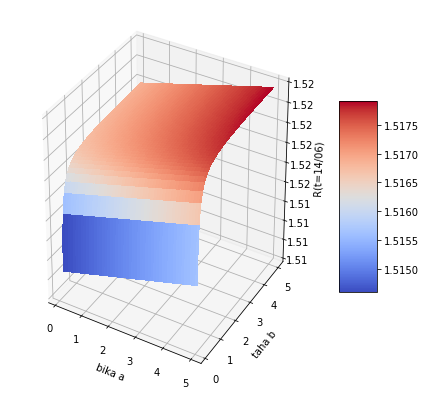

In [14]:
# Variation of R(datyab) with rapport to the prior parameters

datyab = daty_data_mifar

fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')

# Make data.
X = np.linspace(0.1,5,100)
Y = np.linspace(0.1,5,100)
X, Y = np.meshgrid(X, Y)
Z = func_sh(datyab)(X)*func_sc(datyab)(Y)
W = X*Y
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#surf = ax.plot_surface(X, Y, W, cmap=cm.coolwarm,
 #                      linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(1.513, 1.518)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set(xlabel ='bika a', ylabel = "taha b", zlabel = 'R(t=14/06)')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.savefig(path_to_save+'Rt15146_sa.eps')

plt.show()

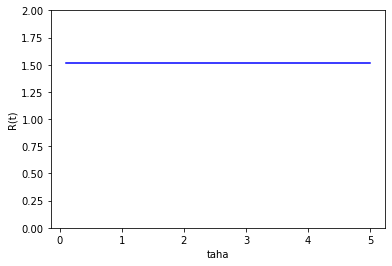

taha* = 1
R(t= 2020-06-14 ) = 1.5169171357485185 = bika*


In [11]:
# R(t) when equality between the prior and the posterior

# 100 linearly spaced numbers
x = np.linspace(0.1,5,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the function
plt.plot(x, x*funcsh_inv(datyab)(x/func_sc(datyab)(x)), 'blue')

ax.set_ylim(0,2)
ax.set(xlabel ='taha', ylabel = "R(t)")


# show the plot
plt.show()

print('taha* = 1')
print('R(t=',datyab,') =', funcsh_inv(datyab)(1/func_sc(datyab)(1)), '= bika*')


## Fanombanana ny Rt

In [15]:
#shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh

# Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc


def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[1e-11, 1e+11])

def Rt_salan(t):
    ffunc_sh = func_sh(t)
    ffunc_sc = func_sc(t)
    ffuncsh_inv = funcsh_inv(t)
    return ffuncsh_inv(1/ffunc_sc(1))

# The 95th and 5th percentiles of Rt

def perc75(t):
    return gengamma.ppf(0.75, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))

def perc25(t):
    return gengamma.ppf(0.25, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))


def Rtps_sal(t):
  return dIvao['Cases'].loc[format_date(t)]/lsi(t)

print("Kajy mivantana ny R hoan'ny", daty_data_mifar, ':', Rtps_sal(daty_data_mifar))

daty_oh1 = datetime.date(2020,6,8)
print("Salan'isa R hoan'ny", daty_oh1, ':', Rt_salan(daty_oh1))
print("Kartily @ 75% R hoan'ny", daty_oh1, ':', perc75(daty_oh1))
print("Kartily @ 25% R hoan'ny", daty_oh1, ':', perc25(daty_oh1))

print("Salan'isa R hoan'ny", daty_data_mifar, ':', Rt_salan(daty_data_mifar))
print("Kartily @ 75% R hoan'ny", daty_data_mifar, ':', perc75(daty_data_mifar))
print("Kartily @ 25% R hoan'ny", daty_data_mifar, ':', perc25(daty_data_mifar))


Kajy mivantana ny R hoan'ny 2020-06-14 : 1.579536883590935
Salan'isa R hoan'ny 2020-06-08 : 1.347498143305714
Kartily @ 75% R hoan'ny 2020-06-08 : 1.360494710536675
Kartily @ 25% R hoan'ny 2020-06-08 : 1.3344006716104655
Salan'isa R hoan'ny 2020-06-14 : 1.5169171364495586
Kartily @ 75% R hoan'ny 2020-06-14 : 1.5289618709803203
Kartily @ 25% R hoan'ny 2020-06-14 : 1.5047955106861215


In [16]:
# Plotting everything except the first 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_lst = []

data_Rt_lst = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) -7)):
  t = daty_data_manom + datetime.timedelta(days = i+1 +7)
  data_amboar = [gengamma.rvs( func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1)) for j in range(400)]
  daty_lst.append(formatf_date(t))
  data_Rt_lst.append(data_amboar)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


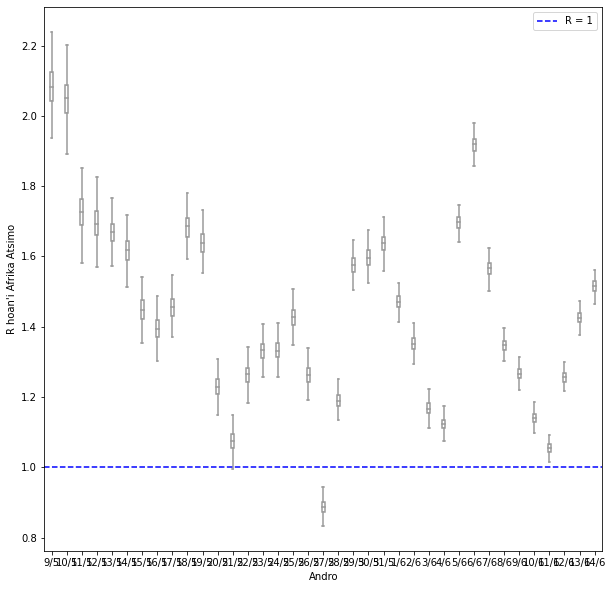

In [17]:
# Plotting everything except the first 7 days


fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(daty_lst, data_Rt_lst, color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'i Afrika Atsimo")
ax.legend(loc= 'best')


plt.savefig(path_to_save+'Rt15146_sa.eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


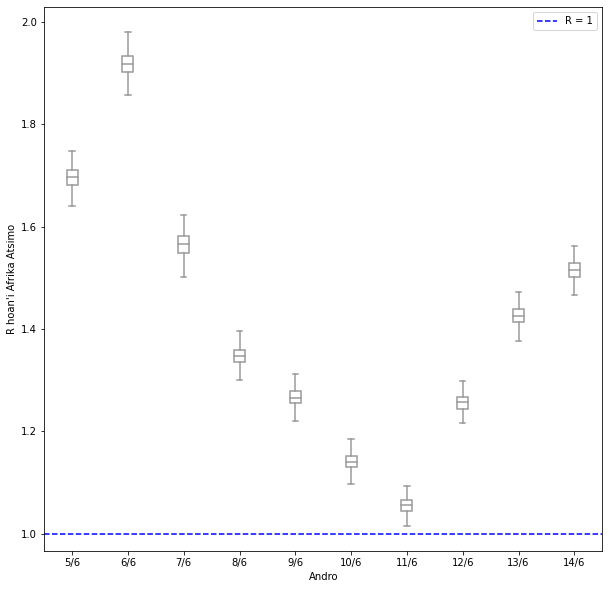

In [18]:
# Plotting the last 10 days before daty_data_mifar


fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(daty_lst[len(daty_lst)-10:len(daty_lst)], data_Rt_lst[len(daty_lst)-10:len(daty_lst)], color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'i Afrika Atsimo")
ax.legend(loc= 'best')


plt.savefig(path_to_save+'Rt1514610_sa.eps')
plt.show()

# Egypt

In [20]:
# Voa vaovao (observed incidence)
Ivao = dataweg['Cases']

dIvao = pd.DataFrame(data =Ivao)

dIvao.sort_index(inplace=True)

# ireo daty fanombohana sy fiafaran'ny antontan'isa raisina
# (Time range of data used for the estimation)

daty_data_manom = datetime.date(2020,5,1)
daty_data_mifar = datetime.date(2020,6,14)

datyt = daty_data_mifar

format_date = lambda date_py: '{}-{}-{}'.format(date_py.year, date_py.month, date_py.day)
datyf_data_manom = format_date(daty_data_manom)
datyf_data_mifar = format_date(daty_data_mifar)

# 0/ Discretization of the serial interval distribution

#Tombana mialoha (prior distributions)
#si_sh = 1/(0.62**2) # Report 13
#si_sc = 6.5/si_sh

si_sh = (6.48**2)/(3.83**2) # Jereo Imperial Covid-19 COVID-19 response team: Short-term forecasts
si_sc = 6.48/si_sh

def discr_si(t):
  if t == 0:
    discrsi = 0
  elif t == 1:
    discrsi = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)
  else:
    discrsi = gengamma.cdf(t+1/2, si_sh, 1, loc = 0, scale = si_sc) - gengamma.cdf(t-1/2, si_sh, 1, loc = 0, scale = si_sc)
  return discrsi

# 1/ The total incidence over a generic window (t-k+1,t)
# Ireh(t,k) = sum(i = 0 to k-1) Ivao(t - i))

def Ireh(t,k):
  Irehv = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      Irehv = Irehv + dIvao['Cases'].loc[format_date(t - datetime.timedelta(days = i))]
  else:
    for i in range(k):
      Irehv = Irehv + dIvao['Cases'].loc[format_date(t - datetime.timedelta(days = i))]
  return Irehv

# 2/ Tool to compute the total infectiousness over a generic window (t-k+1,t)
# Isi(t,k) = sum(i=0 to k-1) Ivao(t - i)*discr_si(i)

# The definition of Isi(t,k) does not include the term Ivao(t) for i = 0 (because discr_si(0) =0)
# so we can start the sum from i = 1; but it includes the last term Ivao(t - k + 1)*discr_si(k - 1) for i = k-1. 

def Isi(t,k):
  Ivaosi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range(1,(t - daty_data_manom).days + 1):
      Ivaosi = Ivaosi + dIvao['Cases'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  else:
    for i in range(1,k):
      Ivaosi = Ivaosi + dIvao['Cases'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  return Ivaosi

# The total infectiousness before t

# lsi(t) := sum(i=0 to t-1) Ivao(t - i)*discr_si(i)

def lsi(t):
  return Isi(t, (t - daty_data_manom).days +1)

  # for checking, take for example t = daty_data_manom + datetime.timedelta(days = 3)

# 3/ The sum of total infectiousness before t over a generic window (t-k+1,t)
# tlsi(t) := sum(i=t-k+1 to t)lsi(i)

def tlsi(t,k):
  tlsi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  else:
    for i in range(k):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  return tlsi

# 4/ The shape parameters of the posterior predictive negative binomial of I(t+1)

# pnb(t,k) = lsi(t+1)*Gamma_post_scale(R(t,k))/(1 + lsi(t+1)*Gamma_post_scale(R(t,k)))

def pnb(t,k):
  return lsi(t+datetime.timedelta(days = 1))/(1/si_sc + tlsi(t,k) + lsi(t+datetime.timedelta(days = 1)))

# pnb(t,k) dia ny taha herjika hoan'ny NB hoan'ny I(t+1).

# 5/ Use the pmf of the posterior predictive negative binomial to compute
# each additive contribution at time s then for-loop for s in the time interval

def lpr(t,k):
  return -np.log(nbinom.pmf(dIvao['Cases'].loc[format_date(t + datetime.timedelta(days = 1))], si_sh + Ireh(t,k), pnb(t,k)))


In [21]:
# 6/ Computation of the Accumulated Predictive Error

# APE9_part1 

APEt91 = []
Prt91 = []

APE91 = 0

for i in range((daty_data_mifar - daty_data_manom).days - 9 + 1):
  t = daty_data_mifar - datetime.timedelta(days = i+1) 
  k = 9
  APE91 = APE91 + lpr(t,k)
  APEt91.append((lpr(t,k),t))
  Prt91.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE91 =', APE91)
print('APEt91 =', APEt91)
print('Prt91 =', Prt91)

# APE9_part2 

APEt92 = []
Prt92 = []

APE92 = 0
for i in range(7):
  t = daty_data_manom - datetime.timedelta(days = i -7)
  k = 9 - 1 - i
  APE92 = APE92 + lpr(t,k) 
  APEt92.append((lpr(t,k),t,k))
  Prt92.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE92 =', APE92)
print('APEt92=', APEt92)
print('Prt92=', Prt92)

# For t_man such that Ivao(t_man) = Ivao(t_man + 1) = 0, we have :
# lsi(t_man + 1) = tlsi(t_man + 1, 2) = Ireh(t_man + 1, 2) = 0,
# so that pnb(t_man + 1, 2) = 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in log


For k = 9, APE91 = inf
APEt91 = [(inf, datetime.date(2020, 6, 13)), (inf, datetime.date(2020, 6, 12)), (inf, datetime.date(2020, 6, 11)), (inf, datetime.date(2020, 6, 10)), (inf, datetime.date(2020, 6, 9)), (inf, datetime.date(2020, 6, 8)), (inf, datetime.date(2020, 6, 7)), (inf, datetime.date(2020, 6, 6)), (inf, datetime.date(2020, 6, 5)), (inf, datetime.date(2020, 6, 4)), (inf, datetime.date(2020, 6, 3)), (inf, datetime.date(2020, 6, 2)), (inf, datetime.date(2020, 6, 1)), (inf, datetime.date(2020, 5, 31)), (inf, datetime.date(2020, 5, 30)), (inf, datetime.date(2020, 5, 29)), (inf, datetime.date(2020, 5, 28)), (inf, datetime.date(2020, 5, 27)), (inf, datetime.date(2020, 5, 26)), (inf, datetime.date(2020, 5, 25)), (inf, datetime.date(2020, 5, 24)), (inf, datetime.date(2020, 5, 23)), (inf, datetime.date(2020, 5, 22)), (inf, datetime.date(2020, 5, 21)), (inf, datetime.date(2020, 5, 20)), (inf, datetime.date(2020, 5, 19)), (inf, datetime.date(2020, 5, 18)), (inf, datetime.date(2020, 5, 17

In [22]:
# APEk part 1 for k =/= 9

# for i in range(t_mif - t_man -j)

APEk1 = []
#APEt21 = []
for j in range(2,9):
  APEj1 = 0
  for i in range(round(((daty_data_mifar - daty_data_manom).days) - j)):
    t = daty_data_mifar - datetime.timedelta(days = i+1) 
    k = j
    APEj1 = APEj1 + lpr(t,k)
   # APEt21.append(lpr(t,k))
  APEk1.append(APEj1)

print('APEk1 =', APEk1)
#print('APEt21 =', APEt21)

# APEk part 2 for k =/= 9

Prk2 = []

APEk2 = []

for j in range(2,9):
  APEj2 = 0
  for i in range(j-1):
    t = daty_data_manom + datetime.timedelta(days = j - i - 1)
    k = j - i
    APEj2 = APEj2 + lpr(t,k)
  APEk2.append(APEj2)

print('APEk2 =', APEk2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in log


APEk1 = [inf, inf, inf, inf, inf, inf, inf]
APEk2 = [24.068619954145333, 104.58208067759136, 391.265023501287, 1065.5544545838623, inf, inf, inf]


In [23]:
# APEk for k = 2,...,8

APEk = [x + y for x, y in zip(APEk1, APEk2)]

# APE9
APE9 = APE91 + APE92

APE = APEk + [APE9]
kk = APE.index(min(APE)) +2
print('APE9 =', APE9)
print('APEk =', APEk)
print('APE =', APE)
print(kk)


APE9 = inf
APEk = [inf, inf, inf, inf, inf, inf, inf]
APE = [inf, inf, inf, inf, inf, inf, inf, inf]
2


## Fifidianana ireo taha mialoha (prior parameters)

In [24]:

  #shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh
  # Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc

def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[0.01, 1e+11])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


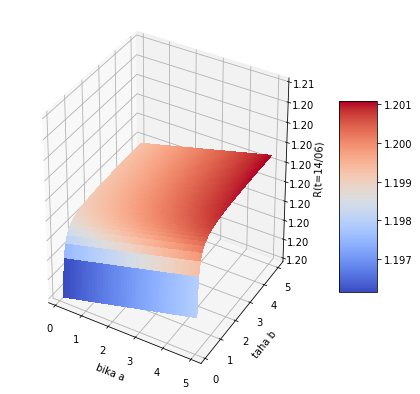

In [27]:
# Variation of R(datyab) with rapport to the prior parameters

datyab = daty_data_mifar

fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')

# Make data.
X = np.linspace(0.1,5,100)
Y = np.linspace(0.1,5,100)
X, Y = np.meshgrid(X, Y)
Z = func_sh(datyab)(X)*func_sc(datyab)(Y)
W = X*Y
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#surf = ax.plot_surface(X, Y, W, cmap=cm.coolwarm,
 #                      linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(1.195, 1.205)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set(xlabel ='bika a', ylabel = "taha b", zlabel = 'R(t=14/06)')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.savefig(path_to_save+'Rt15146_eg.eps')

plt.show()

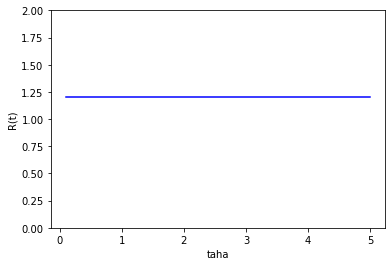

taha* = 1
R(t= 2020-06-14 ) = 1.1993267807787755 = bika*


In [28]:
# R(t) when equality between the prior and the posterior

# 100 linearly spaced numbers
x = np.linspace(0.1,5,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the function
plt.plot(x, x*funcsh_inv(datyab)(x/func_sc(datyab)(x)), 'blue')

ax.set_ylim(0,2)
ax.set(xlabel ='taha', ylabel = "R(t)")


# show the plot
plt.show()

print('taha* = 1')
print('R(t=',datyab,') =', funcsh_inv(datyab)(1/func_sc(datyab)(1)), '= bika*')


## Fanombanana ny Rt

In [29]:
#shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh

# Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc


def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[1e-11, 1e+11])

def Rt_salan(t):
    ffunc_sh = func_sh(t)
    ffunc_sc = func_sc(t)
    ffuncsh_inv = funcsh_inv(t)
    return ffuncsh_inv(1/ffunc_sc(1))

# The 95th and 5th percentiles of Rt

def perc75(t):
    return gengamma.ppf(0.75, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))

def perc25(t):
    return gengamma.ppf(0.25, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))


def Rtps_sal(t):
  return dIvao['Cases'].loc[format_date(t)]/lsi(t)

print("Kajy mivantana ny R hoan'ny", daty_data_mifar, ':', Rtps_sal(daty_data_mifar))

daty_oh1 = datetime.date(2020,6,8)
print("Salan'isa R hoan'ny", daty_oh1, ':', Rt_salan(daty_oh1))
print("Kartily @ 75% R hoan'ny", daty_oh1, ':', perc75(daty_oh1))
print("Kartily @ 25% R hoan'ny", daty_oh1, ':', perc25(daty_oh1))

print("Salan'isa R hoan'ny", daty_data_mifar, ':', Rt_salan(daty_data_mifar))
print("Kartily @ 75% R hoan'ny", daty_data_mifar, ':', perc75(daty_data_mifar))
print("Kartily @ 25% R hoan'ny", daty_data_mifar, ':', perc25(daty_data_mifar))


Kajy mivantana ny R hoan'ny 2020-06-14 : 1.2241282248504737
Salan'isa R hoan'ny 2020-06-08 : 1.2426502515178794
Kartily @ 75% R hoan'ny 2020-06-08 : 1.2579651401145422
Kartily @ 25% R hoan'ny 2020-06-08 : 1.2271830918416518
Salan'isa R hoan'ny 2020-06-14 : 1.1993267807925143
Kartily @ 75% R hoan'ny 2020-06-14 : 1.21343734871123
Kartily @ 25% R hoan'ny 2020-06-14 : 1.1850823369858057


In [30]:
# Plotting everything except the first 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_lst = []

data_Rt_lst = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) -7)):
  t = daty_data_manom + datetime.timedelta(days = i+1 +7)
  data_amboar = [gengamma.rvs( func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1)) for j in range(400)]
  daty_lst.append(formatf_date(t))
  data_Rt_lst.append(data_amboar)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


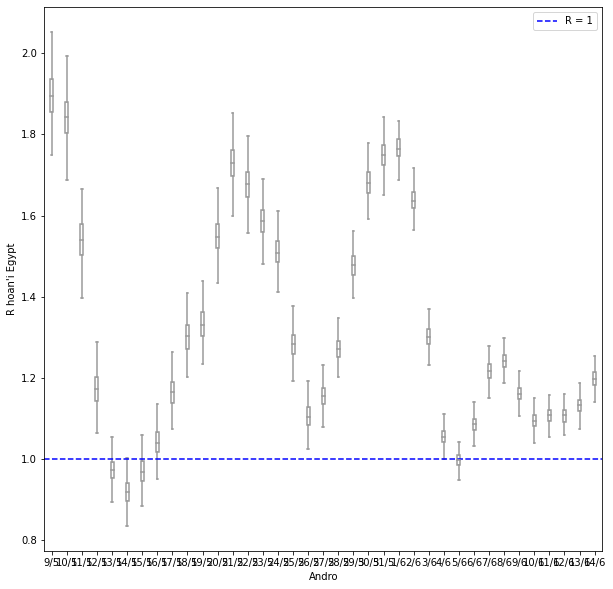

In [31]:
# Plotting everything except the first 7 days


fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(daty_lst, data_Rt_lst, color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'i Egypt")
ax.legend(loc= 'best')


plt.savefig(path_to_save+'Rt15146_eg.eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


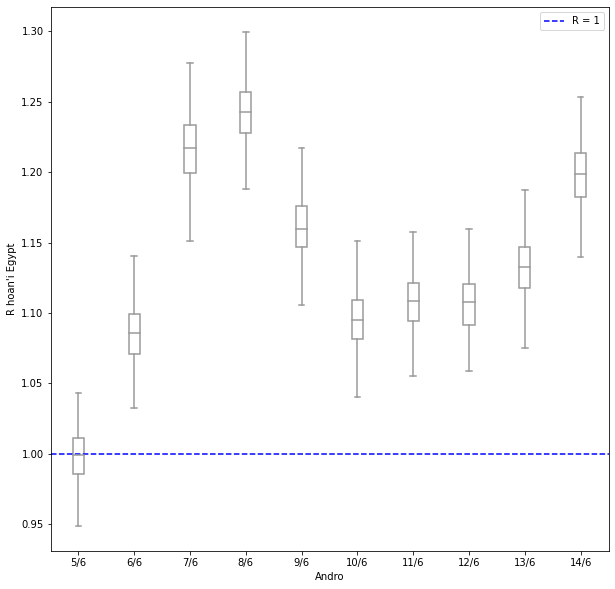

In [32]:
# Plotting the last 10 days before daty_data_mifar


fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(daty_lst[len(daty_lst)-10:len(daty_lst)], data_Rt_lst[len(daty_lst)-10:len(daty_lst)], color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'i Egypt")
ax.legend(loc= 'best')


plt.savefig(path_to_save+'Rt1514610_eg.eps')
plt.show()